In [1625]:
import numpy as np
import math

In [1626]:
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))

## 1.1 ##

In [1987]:
sigma = 0.30
a = 0.05
deltat = 1/12
V = sigma**2 * (1-np.exp(-2*a*deltat))/(2*a)
deltau = np.sqrt(3*V)
numMonths = 24
P = lambda x: np.e**(-0.06 * x * deltat)

In [1988]:
OU = np.zeros((numMonths*2 + 1,numMonths))

In [1989]:
for i in range(int(numMonths)):
    index1 = int(numMonths - i - 1)
    index2 = int(numMonths + i + 1)
    OU[index1][:] = (i+1) * deltau
    OU[index2][:] = -(i+1) * deltau

## 1.2 ##

In [1990]:
intermediateParams = np.zeros((numMonths*2 + 1, 6))

In [1991]:
intermediateParams[:,0] = np.arange(numMonths, -numMonths-1,-1)
intermediateParams[:,1] = np.arange(numMonths, -numMonths-1,-1)

In [1992]:
for i in range(numMonths*2 + 1):
    intermediateParams[i,2] = intermediateParams[i,0] * np.exp(-a * deltat) - math.floor(intermediateParams[i,0]*np.exp(-a * deltat) + 1/2)

In [1993]:
for i in range(numMonths*2 + 1):
    Beta = intermediateParams[i,2]
    intermediateParams[i,3] = 1/6 + 1/2*(Beta**2 + Beta)

In [1994]:
for i in range(numMonths*2 + 1):
    Beta = intermediateParams[i,2]
    intermediateParams[i,4] = 2/3 - (Beta**2)

In [1995]:
for i in range(numMonths*2 + 1):
    Beta = intermediateParams[i,2]
    intermediateParams[i,5] = 1/6 + 1/2*(Beta**2 - Beta)

## 1.3/1.4 ##

In [1996]:
AD = np.zeros((numMonths*2 + 1,numMonths))
AD[numMonths,0] = 1

In [1997]:
r = np.zeros((numMonths*2 + 1, numMonths))
r[numMonths,0] = -np.log(P(1))/(1/12)

In [1998]:
from sympy import symbols, Eq, solve, lambdify, nsolve

for i in range(1,numMonths):
#for i in range(1,2):
    
    r0 = symbols('r0')
    P_sumAD = AD[numMonths,i-1]*np.e**(-r0*deltat)*intermediateParams[numMonths,4] + AD[numMonths+1,i-1]*np.e**(-r0*np.e**(OU[numMonths+1,i-1])*deltat)*intermediateParams[numMonths,3] + AD[numMonths-1,i-1]*np.e**(-r0*np.e**(OU[numMonths-1,i-1])*deltat)*intermediateParams[numMonths,5]
    #-P(i) +
    #update r values for one step ahead
    for j in range(i):
        # if i-j == 1
        if i-j == 1:
            P_sumAD += AD[numMonths-j,i-1]*np.e**(-r0*np.e**(OU[numMonths-j,i-1])*deltat)*intermediateParams[numMonths-j,3]
            P_sumAD += AD[numMonths+j,i-1]*np.e**(-r0*np.e**(OU[numMonths+j,i-1])*deltat)*intermediateParams[numMonths+j,5]

        # if i-j == 2
        if i-j == 2:
            P_sumAD += AD[numMonths-j,i-1]*np.e**(-r0*np.e**(OU[numMonths-j,i-1])*deltat)*intermediateParams[numMonths-j,3]
            P_sumAD += AD[numMonths+j,i-1]*np.e**(-r0*np.e**(OU[numMonths+j,i-1])*deltat)*intermediateParams[numMonths+j,5]

            P_sumAD += AD[numMonths-j-1,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-1,i-1])*deltat)*intermediateParams[numMonths-j-1,4]
            P_sumAD += AD[numMonths+j+1,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+1,i-1])*deltat)*intermediateParams[numMonths+j+1,4]

        # if i-j == 3
        if i-j >= 3:
            P_sumAD += AD[numMonths-j,i-1]*np.e**(-r0*np.e**(OU[numMonths-j,i-1])*deltat)*intermediateParams[numMonths-j,3]
            P_sumAD += AD[numMonths+j,i-1]*np.e**(-r0*np.e**(OU[numMonths+j,i-1])*deltat)*intermediateParams[numMonths+j,5]

            P_sumAD += AD[numMonths-j-1,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-1,i-1])*deltat)*intermediateParams[numMonths-j-1,4]
            P_sumAD += AD[numMonths+j+1,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+1,i-1])*deltat)*intermediateParams[numMonths+j+1,4] 

            P_sumAD += AD[numMonths-j-2,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-2,i-1])*deltat)*intermediateParams[numMonths-j-2,5]
            P_sumAD += AD[numMonths+j+2,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+2,i-1])*deltat)*intermediateParams[numMonths+j+2,3]
      
    eq1 = Eq(P_sumAD,P(i))
    solution = sympy.nsolve(eq1,0)
    
    #update ri(0)
    r[numMonths, i-1] = solution                                             
    #update r matrix based off ri(0) * exp(OUij)
    for j in range(i-1):
        r[numMonths + j + 1 , i-1 ] = r[numMonths, i-1] * np.exp(OU[numMonths + j + 1, i-1])
        r[numMonths - j - 1 , i-1 ] = r[numMonths, i-1] * np.exp(OU[numMonths - j - 1, i-1])
        
    for j in range(i):
        
        Pd_down_iter = intermediateParams[numMonths + j,5]
        Pm_down_iter = intermediateParams[numMonths + j,4]
        Pu_down_iter = intermediateParams[numMonths + j,3]
        
        Pd_up_iter = intermediateParams[numMonths - j,5]
        Pm_up_iter = intermediateParams[numMonths - j,4]
        Pu_up_iter = intermediateParams[numMonths - j,3]
        
        #find one step forward Arrow-Debreu Prices
        AD[numMonths - j - 1, i ] = abs(AD[numMonths - j , i - 1 ])*Pd_up_iter*np.exp(-r[numMonths - j, i - 1]*deltat) + abs(AD[numMonths - j - 1, i - 1 ])*Pm_up_iter*np.exp(-r[numMonths - j - 1, i - 1]*deltat) + abs(AD[numMonths - j - 2, i - 1 ])*Pu_up_iter*np.exp(-r[numMonths - j - 2, i - 1]*deltat)
        AD[numMonths, i ] = abs(AD[numMonths + 1, i-1])*intermediateParams[numMonths,5]*np.exp(-r[numMonths + 1, i - 1]*deltat) + abs(AD[numMonths, i-1])*intermediateParams[numMonths,4]*np.exp(-r[numMonths , i - 1]*deltat) + abs(AD[numMonths +1, i-1])*intermediateParams[numMonths,3]*np.exp(-r[numMonths + 1, i - 1]*deltat)
        AD[numMonths + j + 1, i ] = abs(AD[numMonths + j , i - 1 ])*Pd_down_iter*np.exp(-r[numMonths + j, i - 1]*deltat) + abs(AD[numMonths + j + 1, i - 1 ])*Pm_down_iter*np.exp(-r[numMonths + j + 1, i - 1]*deltat) + abs(AD[numMonths + j + 2, i - 1 ])*Pu_down_iter*np.exp(-r[numMonths + j + 2, i - 1]*deltat)   
    

In [1999]:
i = 24
r0 = symbols('r0')
P_sumAD = AD[numMonths,i-1]*np.e**(-r0*deltat)*intermediateParams[numMonths,4] + AD[numMonths+1,i-1]*np.e**(-r0*np.e**(OU[numMonths+1,i-1])*deltat)*intermediateParams[numMonths,3] + AD[numMonths-1,i-1]*np.e**(-r0*np.e**(OU[numMonths-1,i-1])*deltat)*intermediateParams[numMonths,5]
#-P(i) +
#update r values for one step ahead
for j in range(i):
    # if i-j == 1
    if i-j == 1:
        P_sumAD += AD[numMonths-j,i-1]*np.e**(-r0*np.e**(OU[numMonths-j,i-1])*deltat)*intermediateParams[numMonths-j,3]
        P_sumAD += AD[numMonths+j,i-1]*np.e**(-r0*np.e**(OU[numMonths+j,i-1])*deltat)*intermediateParams[numMonths+j,5]

        # if i-j == 2
    if i-j == 2:
        P_sumAD += AD[numMonths-j,i-1]*np.e**(-r0*np.e**(OU[numMonths-j,i-1])*deltat)*intermediateParams[numMonths-j,3]
        P_sumAD += AD[numMonths+j,i-1]*np.e**(-r0*np.e**(OU[numMonths+j,i-1])*deltat)*intermediateParams[numMonths+j,5]

        P_sumAD += AD[numMonths-j-1,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-1,i-1])*deltat)*intermediateParams[numMonths-j-1,4]
        P_sumAD += AD[numMonths+j+1,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+1,i-1])*deltat)*intermediateParams[numMonths+j+1,4]

        # if i-j == 3
    if i-j >= 3:
        P_sumAD += AD[numMonths-j,i-1]*np.e**(-r0*np.e**(OU[numMonths-j,i-1])*deltat)*intermediateParams[numMonths-j,3]
        P_sumAD += AD[numMonths+j,i-1]*np.e**(-r0*np.e**(OU[numMonths+j,i-1])*deltat)*intermediateParams[numMonths+j,5]

        P_sumAD += AD[numMonths-j-1,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-1,i-1])*deltat)*intermediateParams[numMonths-j-1,4]
        P_sumAD += AD[numMonths+j+1,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+1,i-1])*deltat)*intermediateParams[numMonths+j+1,4] 

        P_sumAD += AD[numMonths-j-2,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-2,i-1])*deltat)*intermediateParams[numMonths-j-2,5]
        P_sumAD += AD[numMonths+j+2,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+2,i-1])*deltat)*intermediateParams[numMonths+j+2,3]
      
eq1 = Eq(P_sumAD,P(i))
solution = sympy.nsolve(eq1,0)
    
    #update ri(0)
r[numMonths, i-1] = solution                                             
    #update r matrix based off ri(0) * exp(OUij)
for j in range(i-1):
    r[numMonths + j + 1 , i-1 ] = r[numMonths, i-1] * np.exp(OU[numMonths + j + 1, i-1])
    r[numMonths - j - 1 , i-1 ] = r[numMonths, i-1] * np.exp(OU[numMonths - j - 1, i-1])

## 1.5

In [2081]:
deltat = 1/4
P = lambda x: np.e**(-0.06 * x * deltat)
numMonths = 8 #This is actually number of quarters but I am not changing the variable name

In [2082]:
intermediateParams = np.zeros((numMonths*2 + 1, 6))

In [2083]:
intermediateParams[:,0] = np.arange(numMonths, -numMonths-1,-1)
intermediateParams[:,1] = np.arange(numMonths, -numMonths-1,-1)

In [2084]:
for i in range(numMonths*2 + 1):
    intermediateParams[i,2] = intermediateParams[i,0] * np.exp(-a * deltat) - math.floor(intermediateParams[i,0]*np.exp(-a * deltat) + 1/2)

In [2085]:
for i in range(numMonths*2 + 1):
    Beta = intermediateParams[i,2]
    intermediateParams[i,3] = 1/6 + 1/2*(Beta**2 + Beta)

In [2086]:
for i in range(numMonths*2 + 1):
    Beta = intermediateParams[i,2]
    intermediateParams[i,4] = 2/3 - (Beta**2)

In [2087]:
for i in range(numMonths*2 + 1):
    Beta = intermediateParams[i,2]
    intermediateParams[i,5] = 1/6 + 1/2*(Beta**2 - Beta)

In [2088]:
AD = np.zeros((numMonths*2 + 1,numMonths))
AD[numMonths,0] = 1

In [2089]:
r = np.zeros((numMonths*2 + 1, numMonths))
r[numMonths,0] = -np.log(P(1))/(1/4)

In [2090]:
from sympy import symbols, Eq, solve, lambdify, nsolve

for i in range(1,numMonths):
#for i in range(1,2):
    
    r0 = symbols('r0')
    P_sumAD = AD[numMonths,i-1]*np.e**(-r0*deltat)*intermediateParams[numMonths,4] + AD[numMonths+1,i-1]*np.e**(-r0*np.e**(OU[numMonths+1,i-1])*deltat)*intermediateParams[numMonths,3] + AD[numMonths-1,i-1]*np.e**(-r0*np.e**(OU[numMonths-1,i-1])*deltat)*intermediateParams[numMonths,5]
    #-P(i) +
    #update r values for one step ahead
    for j in range(i):
        # if i-j == 1
        if i-j == 1:
            P_sumAD += AD[numMonths-j,i-1]*np.e**(-r0*np.e**(OU[numMonths-j,i-1])*deltat)*intermediateParams[numMonths-j,3]
            P_sumAD += AD[numMonths+j,i-1]*np.e**(-r0*np.e**(OU[numMonths+j,i-1])*deltat)*intermediateParams[numMonths+j,5]

        # if i-j == 2
        if i-j == 2:
            P_sumAD += AD[numMonths-j,i-1]*np.e**(-r0*np.e**(OU[numMonths-j,i-1])*deltat)*intermediateParams[numMonths-j,3]
            P_sumAD += AD[numMonths+j,i-1]*np.e**(-r0*np.e**(OU[numMonths+j,i-1])*deltat)*intermediateParams[numMonths+j,5]

            P_sumAD += AD[numMonths-j-1,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-1,i-1])*deltat)*intermediateParams[numMonths-j-1,4]
            P_sumAD += AD[numMonths+j+1,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+1,i-1])*deltat)*intermediateParams[numMonths+j+1,4]

        # if i-j == 3
        if i-j >= 3:
            P_sumAD += AD[numMonths-j,i-1]*np.e**(-r0*np.e**(OU[numMonths-j,i-1])*deltat)*intermediateParams[numMonths-j,3]
            P_sumAD += AD[numMonths+j,i-1]*np.e**(-r0*np.e**(OU[numMonths+j,i-1])*deltat)*intermediateParams[numMonths+j,5]

            P_sumAD += AD[numMonths-j-1,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-1,i-1])*deltat)*intermediateParams[numMonths-j-1,4]
            P_sumAD += AD[numMonths+j+1,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+1,i-1])*deltat)*intermediateParams[numMonths+j+1,4] 

            P_sumAD += AD[numMonths-j-2,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-2,i-1])*deltat)*intermediateParams[numMonths-j-2,5]
            P_sumAD += AD[numMonths+j+2,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+2,i-1])*deltat)*intermediateParams[numMonths+j+2,3]
      
    eq1 = Eq(P_sumAD,P(i))
    solution = sympy.nsolve(eq1,0)
    
    #update ri(0)
    r[numMonths, i-1] = solution                                             
    #update r matrix based off ri(0) * exp(OUij)
    for j in range(i-1):
        r[numMonths + j + 1 , i-1 ] = r[numMonths, i-1] * np.exp(OU[numMonths + j + 1, i-1])
        r[numMonths - j - 1 , i-1 ] = r[numMonths, i-1] * np.exp(OU[numMonths - j - 1, i-1])
        
    for j in range(i):
        
        Pd_down_iter = intermediateParams[numMonths + j,5]
        Pm_down_iter = intermediateParams[numMonths + j,4]
        Pu_down_iter = intermediateParams[numMonths + j,3]
        
        Pd_up_iter = intermediateParams[numMonths - j,5]
        Pm_up_iter = intermediateParams[numMonths - j,4]
        Pu_up_iter = intermediateParams[numMonths - j,3]
        
        #find one step forward Arrow-Debreu Prices
        AD[numMonths - j - 1, i ] = abs(AD[numMonths - j , i - 1 ])*Pd_up_iter*np.exp(-r[numMonths - j, i - 1]*deltat) + abs(AD[numMonths - j - 1, i - 1 ])*Pm_up_iter*np.exp(-r[numMonths - j - 1, i - 1]*deltat) + abs(AD[numMonths - j - 2, i - 1 ])*Pu_up_iter*np.exp(-r[numMonths - j - 2, i - 1]*deltat)
        AD[numMonths, i ] = abs(AD[numMonths + 1, i-1])*intermediateParams[numMonths,5]*np.exp(-r[numMonths + 1, i - 1]*deltat) + abs(AD[numMonths, i-1])*intermediateParams[numMonths,4]*np.exp(-r[numMonths , i - 1]*deltat) + abs(AD[numMonths +1, i-1])*intermediateParams[numMonths,3]*np.exp(-r[numMonths + 1, i - 1]*deltat)
        AD[numMonths + j + 1, i ] = abs(AD[numMonths + j , i - 1 ])*Pd_down_iter*np.exp(-r[numMonths + j, i - 1]*deltat) + abs(AD[numMonths + j + 1, i - 1 ])*Pm_down_iter*np.exp(-r[numMonths + j + 1, i - 1]*deltat) + abs(AD[numMonths + j + 2, i - 1 ])*Pu_down_iter*np.exp(-r[numMonths + j + 2, i - 1]*deltat)   
    

In [2091]:
i = 8
r0 = symbols('r0')
P_sumAD = AD[numMonths,i-1]*np.e**(-r0*deltat)*intermediateParams[numMonths,4] + AD[numMonths+1,i-1]*np.e**(-r0*np.e**(OU[numMonths+1,i-1])*deltat)*intermediateParams[numMonths,3] + AD[numMonths-1,i-1]*np.e**(-r0*np.e**(OU[numMonths-1,i-1])*deltat)*intermediateParams[numMonths,5]
#-P(i) +
#update r values for one step ahead
for j in range(i):
    # if i-j == 1
    if i-j == 1:
        P_sumAD += AD[numMonths-j,i-1]*np.e**(-r0*np.e**(OU[numMonths-j,i-1])*deltat)*intermediateParams[numMonths-j,3]
        P_sumAD += AD[numMonths+j,i-1]*np.e**(-r0*np.e**(OU[numMonths+j,i-1])*deltat)*intermediateParams[numMonths+j,5]

        # if i-j == 2
    if i-j == 2:
        P_sumAD += AD[numMonths-j,i-1]*np.e**(-r0*np.e**(OU[numMonths-j,i-1])*deltat)*intermediateParams[numMonths-j,3]
        P_sumAD += AD[numMonths+j,i-1]*np.e**(-r0*np.e**(OU[numMonths+j,i-1])*deltat)*intermediateParams[numMonths+j,5]

        P_sumAD += AD[numMonths-j-1,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-1,i-1])*deltat)*intermediateParams[numMonths-j-1,4]
        P_sumAD += AD[numMonths+j+1,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+1,i-1])*deltat)*intermediateParams[numMonths+j+1,4]

        # if i-j == 3
    if i-j >= 3:
        P_sumAD += AD[numMonths-j,i-1]*np.e**(-r0*np.e**(OU[numMonths-j,i-1])*deltat)*intermediateParams[numMonths-j,3]
        P_sumAD += AD[numMonths+j,i-1]*np.e**(-r0*np.e**(OU[numMonths+j,i-1])*deltat)*intermediateParams[numMonths+j,5]

        P_sumAD += AD[numMonths-j-1,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-1,i-1])*deltat)*intermediateParams[numMonths-j-1,4]
        P_sumAD += AD[numMonths+j+1,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+1,i-1])*deltat)*intermediateParams[numMonths+j+1,4] 

        P_sumAD += AD[numMonths-j-2,i-1]*np.e**(-r0*np.e**(OU[numMonths-j-2,i-1])*deltat)*intermediateParams[numMonths-j-2,5]
        P_sumAD += AD[numMonths+j+2,i-1]*np.e**(-r0*np.e**(OU[numMonths+j+2,i-1])*deltat)*intermediateParams[numMonths+j+2,3]
      
eq1 = Eq(P_sumAD,P(i))
solution = sympy.nsolve(eq1,0)
    
    #update ri(0)
r[numMonths, i-1] = solution                                             
    #update r matrix based off ri(0) * exp(OUij)
for j in range(i-1):
    r[numMonths + j + 1 , i-1 ] = r[numMonths, i-1] * np.exp(OU[numMonths + j + 1, i-1])
    r[numMonths - j - 1 , i-1 ] = r[numMonths, i-1] * np.exp(OU[numMonths - j - 1, i-1])

In [2092]:
#fixed rate bond
T = 24
Principal = 100
quarter = 1/4
coupon = 0.06

In [2093]:
fixedRate = np.zeros(AD.shape,dtype = float)

for i in range(fixedRate.shape[0]):
    fixedRate[i,-1] = Principal + Principal*coupon*quarter

In [2094]:
for i in range(numMonths-1):
    fixedRate[numMonths,numMonths-i-2] = fixedRate[numMonths,numMonths-1-i]*intermediateParams[numMonths,4]*np.e**(-r[numMonths,numMonths-i-2]*quarter) + fixedRate[numMonths+1,numMonths-1-i]*intermediateParams[numMonths,5]*np.e**(-r[numMonths,numMonths-i-2]*quarter) + fixedRate[numMonths-1,numMonths-1-i]*intermediateParams[numMonths,3]*np.e**(-r[numMonths,numMonths-i-2]*quarter) + 1.5
    for j in range(numMonths-i-1):
        fixedRate[numMonths - j -1,numMonths-i-2] = fixedRate[numMonths-j-1,numMonths-1-i]*intermediateParams[numMonths,4]*np.e**(-r[numMonths-j-1,numMonths-i-2]*quarter) + fixedRate[numMonths-j-2,numMonths-1-i]*intermediateParams[numMonths,3]*np.e**(-r[numMonths-j-1,numMonths-i-2]*quarter) + fixedRate[numMonths-j,numMonths-1-i]*intermediateParams[numMonths,5]*np.e**(-r[numMonths-j-1,numMonths-i-2]*quarter) + 1.5
        fixedRate[numMonths + j +1,numMonths-i-2] = fixedRate[numMonths+j+1,numMonths-1-i]*intermediateParams[numMonths,4]*np.e**(-r[numMonths+j+1,numMonths-i-2]*quarter) + fixedRate[numMonths+j+2,numMonths-1-i]*intermediateParams[numMonths,5]*np.e**(-r[numMonths+j+1,numMonths-i-2]*quarter) + fixedRate[numMonths+j,numMonths-1-i]*intermediateParams[numMonths,3]*np.e**(-r[numMonths+j+1,numMonths-i-2]*quarter) + 1.5
              

In [2095]:
fixedRate[numMonths,0]

101.65079932028296

In [2096]:
r = r[1:-1,:]

In [2118]:
#Cap Agreement
T = 24
Principal = 100
Rk = 0.07

In [2119]:
Cf = np.zeros((15,8),dtype = float)

for i in range(Cf.shape[0]):
    Cf[i,-1] = 100 + Principal * quarter * max(r[i,-1]-Rk,0)

In [2123]:
for i in range(numMonths-1):
    Cf[numMonths-1,numMonths-i-2] = Cf[numMonths-1,numMonths-1-i]*intermediateParams[numMonths,4]*np.e**(-r[numMonths-1,numMonths-i-2]*quarter) + Cf[numMonths,numMonths-1-i]*intermediateParams[numMonths,5]*np.e**(-r[numMonths-1,numMonths-i-2]*quarter) + Cf[numMonths-2,numMonths-1-i]*intermediateParams[numMonths,3]*np.e**(-r[numMonths-1,numMonths-i-2]*quarter) + Principal*quarter*max(r[numMonths-1,numMonths-i-2],0)
    for j in range(numMonths-i-2):
        Cf[numMonths - j -2,numMonths-i-2] = Cf[numMonths-j-2,numMonths-1-i]*intermediateParams[numMonths,4]*np.e**(-r[numMonths-j-3,numMonths-i-2]*quarter) + Cf[numMonths-j-3,numMonths-1-i]*intermediateParams[numMonths,3]*np.e**(-r[numMonths-j-2,numMonths-i-2]*quarter) + Cf[numMonths-j-1,numMonths-1-i]*intermediateParams[numMonths,5]*np.e**(-r[numMonths-j-2,numMonths-i-2]*quarter) + Principal*quarter*max(r[numMonths-j-2,numMonths-i-2],0)
        Cf[numMonths + j,numMonths-i-2] = Cf[numMonths+j,numMonths-1-i]*intermediateParams[numMonths,4]*np.e**(-r[numMonths+j,numMonths-i-2]*quarter) + Cf[numMonths+j+1,numMonths-1-i]*intermediateParams[numMonths,5]*np.e**(-r[numMonths+j,numMonths-i-2]*quarter) + Cf[numMonths+j-1,numMonths-1-i]*intermediateParams[numMonths,3]*np.e**(-r[numMonths+j,numMonths-i-2]*quarter) + Principal*quarter*max(r[numMonths+j,numMonths-i-2],0)
              

In [2125]:
Cf[numMonths-1,0]

100.56374970118692

## 2.b ##

In [1762]:
from sympy import symbols , Eq, solve, diff, sqrt, simplify, evalf, log, exp
k = symbols('k')
T = symbols('T')
t = symbols('t')
h = sqrt(k**2 + 2*s**2)
o = symbols('o')
s = symbols('s')
r = symbols('r')

In [1763]:
A = ((2*h * exp((T-t)*(k+h)/2))/(2*h + (k+h)*(exp((T-t)*h)-1)))**(2*k*o/(s**2))
A_prime = diff(A,t)

In [1764]:
A

(2*sqrt(k**2 + 2*s**2)*exp((T - t)*(k + sqrt(k**2 + 2*s**2))/2)/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2)))**(2*k*o/s**2)

In [1765]:
(A_prime)

k*o*(2*sqrt(k**2 + 2*s**2)*exp((T - t)*(k + sqrt(k**2 + 2*s**2))/2)/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2)))**(2*k*o/s**2)*((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2))*(2*(-k/2 - sqrt(k**2 + 2*s**2)/2)*sqrt(k**2 + 2*s**2)*exp((T - t)*(k + sqrt(k**2 + 2*s**2))/2)/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2)) + 2*(k + sqrt(k**2 + 2*s**2))*(k**2 + 2*s**2)*exp((T - t)*(k + sqrt(k**2 + 2*s**2))/2)*exp((T - t)*sqrt(k**2 + 2*s**2))/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2))**2)*exp(-(T - t)*(k + sqrt(k**2 + 2*s**2))/2)/(s**2*sqrt(k**2 + 2*s**2))

In [1766]:
B = (2 * (exp((T-t)*h)-1)) / (2*h + (k + h)*(exp((T-t)*h) - 1))
B_prime = diff(B,t)

In [1767]:
B

(2*exp((T - t)*sqrt(k**2 + 2*s**2)) - 2)/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2))

In [1768]:
B_prime

(k + sqrt(k**2 + 2*s**2))*sqrt(k**2 + 2*s**2)*(2*exp((T - t)*sqrt(k**2 + 2*s**2)) - 2)*exp((T - t)*sqrt(k**2 + 2*s**2))/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2))**2 - 2*sqrt(k**2 + 2*s**2)*exp((T - t)*sqrt(k**2 + 2*s**2))/((k + sqrt(k**2 + 2*s**2))*(exp((T - t)*sqrt(k**2 + 2*s**2)) - 1) + 2*sqrt(k**2 + 2*s**2))

In [1769]:
print(simplify(A_prime - k*o*B*A) == 0)
print(simplify(B_prime + 1 - (1/2*(s**2)*B**2 + k*B))==0)

True
True


In [1770]:
#terminal condition on A
convert = lambdify( ['k','T','t','o','s','r'], A)
sol_r = convert(1,30,30,0.03,0.1,0.01)
print(sol_r)

1.0


In [1771]:
#terminal condition on B
convert = lambdify( ['k','T','t','o','s','r'], -B_prime + 1/2*(s**2)*(B**2) + k*B - 1)
sol_r = convert(1,0,0,0.03,0.1,0.01)
print(sol_r)

0.0


In [1756]:
forwardRate = log(A*exp(-B*r))
forwardRate

log((2*sqrt(k**2 + 0.02)*exp((T - t)*(k + sqrt(k**2 + 0.02))/2)/((k + sqrt(k**2 + 0.02))*(exp((T - t)*sqrt(k**2 + 0.02)) - 1) + 2*sqrt(k**2 + 0.02)))**(2*k*o/s**2)*exp(-r*(2*exp((T - t)*sqrt(k**2 + 0.02)) - 2)/((k + sqrt(k**2 + 0.02))*(exp((T - t)*sqrt(k**2 + 0.02)) - 1) + 2*sqrt(k**2 + 0.02))))

In [1757]:
instantFwdRate = -diff(forwardRate,T)
simplify(instantFwdRate)

instantFwdRateZero = instantFwdRate.subs('t',0)

In [1758]:
convert = lambdify( ['k','T','o','s','r'], instantFwdRateZero)

storedValues = []
x = []
for i in range(31):
    x.append(i)
    storedValues.append(convert(1,i,0.03,0.1,0.01))

In [1759]:
import seaborn as sns

/Users/sethkelley/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


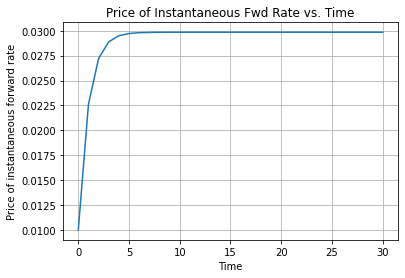

In [1760]:
ax = sns.lineplot(x,storedValues)
ax.set(xlabel = 'Time', ylabel = 'Price of instantaneous forward rate',title = "Price of Instantaneous Fwd Rate vs. Time")
ax.grid()

## 2.c

In [720]:
T = 30
N = 1000
terminalA = 1
terminalB = 0
dt = 30/1000
k = 1 
o = 0.03
s = 0.1

In [721]:
A = []
B = []

A.append(terminalA)
B.append(terminalB)

for i in range(N):
    
    insertA = A[0] - dt*(k*o*A[0]*B[0])
    insertB = B[0] + dt - (1/2*(s**2)*(B[0]**2)+k*B[0])*dt
    
    A.insert(0,insertA)
    B.insert(0,insertB)
    
print("The estimated value of A(0,T) is: " ,np.round(A[0],3)) 
print("The estimated value of B(0,T) is: " ,np.round(B[0],3))  

The estimated value of A(0,T) is:  0.421
The estimated value of B(0,T) is:  0.995


In [667]:
Asym = ((2*h * exp((T-t)*(k+h)/2))/(2*h + (k+h)*(exp((T-t)*h)-1)))**(2*k*o/(s**2))
Bsym = (2 * (exp((T-t)*h)-1)) / (2*h + (k + h)*(exp((T-t)*h) - 1))

In [668]:
#terminal condition on A
convert = lambdify( ['k','T','t','o','s','r'], Asym)
A_zero = convert(1,30,0,0.03,0.1,0.01)
print("The actual value of A(o,T) is: ",np.round(A_zero,3))

The actual value of A(o,T) is:  0.421


In [669]:
#terminal condition on B
convert = lambdify( ['k','T','t','o','s','r'], Bsym)
B_zero = convert(1,30,0,0.03,0.1,0.01)
print("The actual value of B(o,T) is: ",np.round(B_zero,3))

The actual value of B(o,T) is:  0.995


In [670]:
print("The error on A is: ",np.abs(A_zero-A[0])/A_zero)
print("The error on A is: ",np.abs(B_zero-B[0])/B_zero)

The error on A is:  0.00038023432859054894
The error on A is:  2.5215874477736136e-14


## 2.d

In [671]:
T = 30
N = 1000
terminalA = 1
terminalB = 0
dt = 30/1000
k = 1 
o = 0.03
s = 0.1

In [672]:
A = []
B = []

A.append(terminalA)
B.append(terminalB)

for i in range(N):
    
    insertB = (-(1 + k*dt) + np.sqrt((1 + k*dt)**2 + 4*(1/2 * dt * (s**2))*(B[0]+dt)))/(dt*(s**2))
    insertA = A[0]/(1 + dt*k*o*insertB)
    
    A.insert(0,insertA)
    B.insert(0,insertB)
    
print("The estimated value of A(0,T) is: " ,np.round(A[0],3)) 
print("The estimated value of B(0,T) is: " ,np.round(B[0],3))  

The estimated value of A(0,T) is:  0.421
The estimated value of B(0,T) is:  0.995


In [673]:
print("The error on A is: ",np.abs(A_zero-A[0])/A_zero)
print("The error on A is: ",np.abs(B_zero-B[0])/B_zero)

The error on A is:  0.0003797631052428798
The error on A is:  1.4015005349658912e-11


## 2.e

In [791]:
T = 30
k = 12
terminalA = 1
terminalB = 0
o = 0.03
k=1
s = 0.1

In [792]:
Ak = []
Bk = []
Akval = []
Bkval = []

for j in range(1,16):
    A = []
    B = []

    A.append(terminalA)
    B.append(terminalB)
    
    insertA = 0 
    insertB = 0
    
    N = 2**j
    dt = T/N

    for i in range(N):
        insertA = A[0] - dt*(k*o*A[0]*B[0])
        insertB = B[0] + dt - (1/2*(s**2)*(B[0]**2)+k*B[0])*dt

        A.insert(0,insertA)
        B.insert(0,insertB)
        
    Akval.append(A[0])
    Bkval.append(B[0])
    Ak.append("for k = {}, A[0,T] is {}".format(j,np.round(A[0],5)))
    Bk.append("for k = {}, B[0,T] is {}".format(j,np.round(B[0],5)))

In [793]:
Ak

['for k = 1, A[0,T] is -5.75',
 'for k = 2, A[0,T] is 356.70171',
 'for k = 3, A[0,T] is 2379830.05181',
 'for k = 4, A[0,T] is 0.40559',
 'for k = 5, A[0,T] is 0.41554',
 'for k = 6, A[0,T] is 0.41814',
 'for k = 7, A[0,T] is 0.41941',
 'for k = 8, A[0,T] is 0.42004',
 'for k = 9, A[0,T] is 0.42035',
 'for k = 10, A[0,T] is 0.42051',
 'for k = 11, A[0,T] is 0.42059',
 'for k = 12, A[0,T] is 0.42063',
 'for k = 13, A[0,T] is 0.42065',
 'for k = 14, A[0,T] is 0.42066',
 'for k = 15, A[0,T] is 0.42066']

In [794]:
Bk

['for k = 1, B[0,T] is -211.875',
 'for k = 2, B[0,T] is -3210.74696',
 'for k = 3, B[0,T] is -159029.9237',
 'for k = 4, B[0,T] is 0.83123',
 'for k = 5, B[0,T] is 0.99505',
 'for k = 6, B[0,T] is 0.99505',
 'for k = 7, B[0,T] is 0.99505',
 'for k = 8, B[0,T] is 0.99505',
 'for k = 9, B[0,T] is 0.99505',
 'for k = 10, B[0,T] is 0.99505',
 'for k = 11, B[0,T] is 0.99505',
 'for k = 12, B[0,T] is 0.99505',
 'for k = 13, B[0,T] is 0.99505',
 'for k = 14, B[0,T] is 0.99505',
 'for k = 15, B[0,T] is 0.99505']

In [806]:
logError = 1/np.log(2) * np.log(np.sqrt((Akval-A_zero)**2 + (Bkval-B_zero)**2))
logError

array([7.73, 11.7, 21.2, -2.6, -7.61, -8.63, -9.64, -10.6, -11.6, -12.6, -13.6, -14.6, -15.6, -16.6, -17.6])

/Users/sethkelley/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


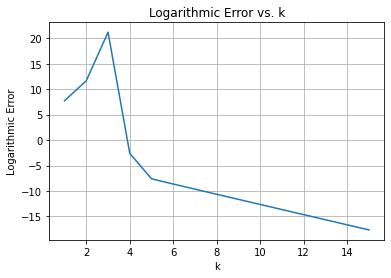

In [810]:
ax2 = sns.lineplot([i for i in range(1,16)],logError)
ax2.set(xlabel = 'k', ylabel = 'Logarithmic Error',title = "Logarithmic Error vs. k")
ax2.grid()

/Users/sethkelley/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


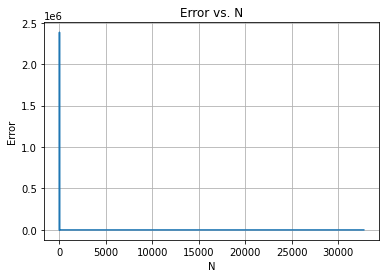

In [811]:
ax3 = sns.lineplot([2**i for i in range(1,16)],np.sqrt((Akval-A_zero)**2 + (Bkval-B_zero)**2))
ax3.set(xlabel = 'N', ylabel = 'Error',title = "Error vs. N")
ax3.grid()

/Users/sethkelley/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


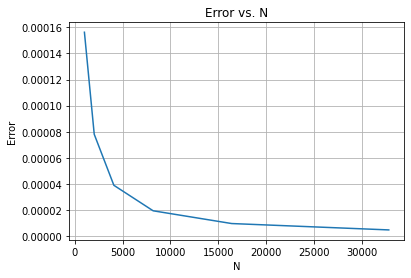

In [824]:
test = np.sqrt((Akval-A_zero)**2 + (Bkval-B_zero)**2)
ax4 = sns.lineplot([2**i for i in range(10,16)],test[9:])
ax4.set(xlabel = 'N', ylabel = 'Error',title = "Error vs. N")
ax4.grid()

The local truncation error of backward Euler Method is O(h^2). This seems to be confirmed by what we see when we analyze the graph of Error vs. N.

## 2.f

In [882]:
T = 30
N = 1000
terminalA = 1
terminalB = 0
dt = 30/1000
k = 1
t = np.arange(0,30,30/1000)
st = 0.1 + 0.05*np.sin(2*np.pi*t/T)
ot = 0.02 + 0.06*t/30

In [883]:
A = []
B = []

A.append(terminalA)
B.append(terminalB)

for i in range(N):
    
    s = st[N-i-1]
    o = ot[N-i-1]
    
    insertA = A[0] - dt*(k*o*A[0]*B[0])
    insertB = B[0] + dt - (1/2*(s**2)*(B[0]**2)+k*B[0])*dt
    
    A.insert(0,insertA)
    B.insert(0,insertB)
    
print("The estimated value of A(0,T) is: " ,np.round(A[0],3)) 
print("The estimated value of B(0,T) is: " ,np.round(B[0],3))  

The estimated value of A(0,T) is:  0.243
The estimated value of B(0,T) is:  0.994


## 2.g

In [889]:
T = np.array([dt*i for i in range(1,1001)])
N = 1000
terminalA = 1
terminalB = 0
dt = 30/1000
o = 0.03
k=1
s = 0.1
r0 = 0.01

In [895]:
Ak = []
Bk = []
Pk = []

Akval = []
Bkval = []
Pkval = []

diffLogP = []

for maturity in T:
    A = []
    B = []
    P = []
    
    A.append(terminalA)
    B.append(terminalB)
    P.append(terminalA * np.exp(-terminalB*r0))
    
    for i in range(int(maturity/(30/1000))):
        insertA = A[0] - dt*(k*o*A[0]*B[0])
        insertB = B[0] + dt - (1/2*(s**2)*(B[0]**2)+k*B[0])*dt
        
        P.insert(0,insertA*np.exp(-insertB * r0))     
        A.insert(0,insertA)
        B.insert(0,insertB)
    
    for e in range(len(P)-1):
        diffLogP.insert(0,(np.log(P[len(P)-1-e]) - np.log(P[len(P)-e-2]))/dt)
    
    Pkval.append(diffLogP[0])
    Akval.append(A[0])
    Bkval.append(B[0])
    Ak.append("for T = {}*dt, A[0,{}*dt] is {}".format(int(maturity/(30/1000)),int(maturity/(30/1000)),np.round(A[0],5)))
    Bk.append("for k = {}, B[0,{}*dt] is {}".format(int(maturity/(30/1000)),int(maturity/(30/1000)),np.round(B[0],5)))

In [891]:
Ak[:10],Ak[990:]

(['for T = 1*dt, A[0,1*dt] is 1.0',
  'for T = 2*dt, A[0,2*dt] is 0.99997',
  'for T = 3*dt, A[0,3*dt] is 0.99992',
  'for T = 4*dt, A[0,4*dt] is 0.99984',
  'for T = 5*dt, A[0,5*dt] is 0.99974',
  'for T = 6*dt, A[0,6*dt] is 0.99961',
  'for T = 7*dt, A[0,7*dt] is 0.99946',
  'for T = 8*dt, A[0,8*dt] is 0.99929',
  'for T = 9*dt, A[0,9*dt] is 0.99909',
  'for T = 10*dt, A[0,10*dt] is 0.99888'],
 ['for T = 991*dt, A[0,991*dt] is 0.42391',
  'for T = 992*dt, A[0,992*dt] is 0.42353',
  'for T = 993*dt, A[0,993*dt] is 0.42315',
  'for T = 994*dt, A[0,994*dt] is 0.42277',
  'for T = 995*dt, A[0,995*dt] is 0.42239',
  'for T = 996*dt, A[0,996*dt] is 0.42202',
  'for T = 997*dt, A[0,997*dt] is 0.42164',
  'for T = 998*dt, A[0,998*dt] is 0.42126',
  'for T = 999*dt, A[0,999*dt] is 0.42088',
  'for T = 1000*dt, A[0,1000*dt] is 0.42051'])

In [892]:
Bk[:10],Bk[990:]

(['for k = 1, B[0,1*dt] is 0.03',
  'for k = 2, B[0,2*dt] is 0.0591',
  'for k = 3, B[0,3*dt] is 0.08733',
  'for k = 4, B[0,4*dt] is 0.11471',
  'for k = 5, B[0,5*dt] is 0.14126',
  'for k = 6, B[0,6*dt] is 0.16702',
  'for k = 7, B[0,7*dt] is 0.19201',
  'for k = 8, B[0,8*dt] is 0.21624',
  'for k = 9, B[0,9*dt] is 0.23975',
  'for k = 10, B[0,10*dt] is 0.26255'],
 ['for k = 991, B[0,991*dt] is 0.99505',
  'for k = 992, B[0,992*dt] is 0.99505',
  'for k = 993, B[0,993*dt] is 0.99505',
  'for k = 994, B[0,994*dt] is 0.99505',
  'for k = 995, B[0,995*dt] is 0.99505',
  'for k = 996, B[0,996*dt] is 0.99505',
  'for k = 997, B[0,997*dt] is 0.99505',
  'for k = 998, B[0,998*dt] is 0.99505',
  'for k = 999, B[0,999*dt] is 0.99505',
  'for k = 1000, B[0,1000*dt] is 0.99505'])

/Users/sethkelley/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


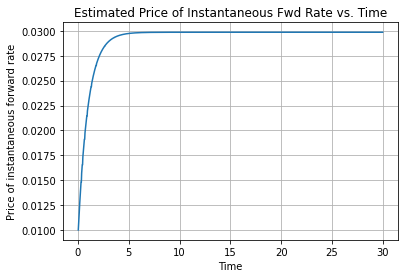

In [896]:
ax5 = sns.lineplot(T,Pkval)
ax5.set(xlabel = 'Time', ylabel = 'Price of instantaneous forward rate',title = "Estimated Price of Instantaneous Fwd Rate vs. Time")
ax5.grid()

## 3.e

In [1150]:
T = 1
K = 1
r = 0.02
delta = 0.3
N = 1000

S0 = K*np.exp(3*delta*np.sqrt(T/K))
sLower = K*np.exp(-3*delta*np.sqrt(T/K))
M = int(1/((S0/1000)**2))
dx = sBar/N
dt = T/M

S = np.arange(S0,sLower,-dx)

In [1151]:
V = np.zeros((len(S),M))

In [1152]:
for i in range(M):
    V[-1,i] = K*np.exp(-r*(T-i*dt)) - K*np.exp(-3*delta*np.sqrt(T/K))

In [1153]:
V[:,-1] = K - S

In [1154]:
for i in range(len(V[:,-1])):
    V[i,-1] = max(V[i,-1],0)

In [1156]:
for i in range(V.shape[1]-1):
    for j in range(V.shape[0]-2):
        sigma = delta * S[j]**(-1/2)
        pUp = (sigma**2)*dt/(2*(dx**2)) + (r - (sigma**2)/2)*dt/(2*dx)
        p = 1 - (sigma**2)*dt/(dx**2)
        pDown = (sigma**2)*dt/(2*(dx**2)) - (r - (sigma**2)/2)*dt/(2*dx)
        
        V[1+j,V.shape[1]-2-i] = V[j,V.shape[1]-1-i]*(pUp) + V[1+j,V.shape[1]-1-i]*(p-r*dt) + V[2+j,V.shape[1]-1-i]*(pDown)

/Users/sethkelley/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


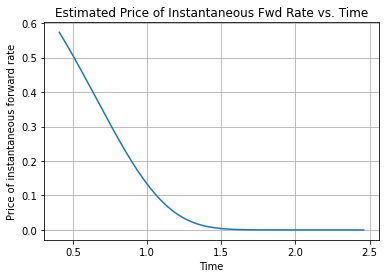

In [1157]:
ax6 = sns.lineplot(S,V[:,0])
ax6.set(xlabel = 'Time', ylabel = 'Price of instantaneous forward rate',title = "Estimated Price of Instantaneous Fwd Rate vs. Time")
ax6.grid()

## 3.f

In [1158]:
T = 1
K = 1
r = 0.02
delta = 0.3
N = 1000

S0 = K*np.exp(3*delta*np.sqrt(T/K))
sLower = K*np.exp(-3*delta*np.sqrt(T/K))
M = 1000
dx = sBar/N
dt = T/M

S = np.arange(S0,sLower,-dx)

In [1159]:
V = np.zeros((len(S),M))

In [1160]:
for i in range(M):
    V[-1,i] = K*np.exp(-r*(T-i*dt)) - K*np.exp(-3*delta*np.sqrt(T/K))

In [1161]:
V[:,-1] = K - S

In [1162]:
for i in range(len(V[:,-1])):
    V[i,-1] = max(V[i,-1],0)

In [1163]:
for i in range(V.shape[1]-1):
    for j in range(V.shape[0]-2):
        sigma = delta * S[j]**(-1/2)
        pUp = (sigma**2)*dt/(2*(dx**2)) + (r - (sigma**2)/2)*dt/(2*dx)
        p = 1 - (sigma**2)*dt/(dx**2)
        pDown = (sigma**2)*dt/(2*(dx**2)) - (r - (sigma**2)/2)*dt/(2*dx)
        
        V[1+j,V.shape[1]-2-i] = V[j,V.shape[1]-1-i]*(pUp) + V[1+j,V.shape[1]-1-i]*(p-r*dt) + V[2+j,V.shape[1]-1-i]*(pDown)

/var/folders/bv/j678dvtd34bc5mtymgsd2c6w0000gn/T/ipykernel_9023/2722469056.py:8: RuntimeWarning: overflow encountered in double_scalars
  V[1+j,V.shape[1]-2-i] = V[j,V.shape[1]-1-i]*(pUp) + V[1+j,V.shape[1]-1-i]*(p-r*dt) + V[2+j,V.shape[1]-1-i]*(pDown)
/var/folders/bv/j678dvtd34bc5mtymgsd2c6w0000gn/T/ipykernel_9023/2722469056.py:8: RuntimeWarning: invalid value encountered in double_scalars
  V[1+j,V.shape[1]-2-i] = V[j,V.shape[1]-1-i]*(pUp) + V[1+j,V.shape[1]-1-i]*(p-r*dt) + V[2+j,V.shape[1]-1-i]*(pDown)


In [1164]:
V

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0

We can see that if M is not suitable for producing stability then we have errors in computing the option price. More generally, we will not have convergence to the true solution.

In some instances we have nan's as our values and in other instances we have produced extremely large numbers that eventually lead to overflow errors.